In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

# Imputing with KNNImputer
from sklearn.impute import KNNImputer

In [27]:
df = pd.read_csv('home_date_miss_values.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df = df[df.date > pd.to_datetime('2022-05-30')]
df

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


# EDA

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   353 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [29]:
df.describe()

,value
count,353.000000
mean,21839.537677
std,4040.851138
min,15470.500000
25%,18937.300000
50%,20957.000000
75%,24210.800000
max,31183.700000


In [6]:
df.value

731     31183.7
732     29328.6
733     29572.8
734     29255.0
735     29450.1
         ...   
1091    26338.0
1092    26554.8
1093    26788.7
1094    27550.0
1095    27559.8
Name: value, Length: 365, dtype: float64

# Заполнение пропусков

In [30]:
df.isnull().sum()

date      0
value    12
dtype: int64

In [31]:
df0 = df.fillna(0) #заполнение нулями
df0

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


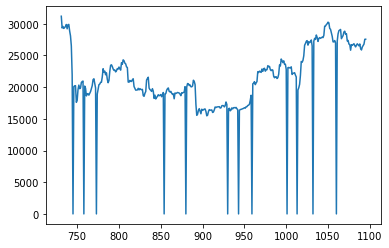

In [33]:
plt.plot(df0['value'])

In [36]:
from sklearn.impute import SimpleImputer

#imputer = SimpleImputer (strategy= 'mean')
#imputer = SimpleImputer (strategy= 'median')
imputer = SimpleImputer (strategy= 'most_frequent') 

df.value = imputer.fit_transform(df['value'].values.reshape(-1,1))

заполняем пропуски подборм значений, которые часто посторяются

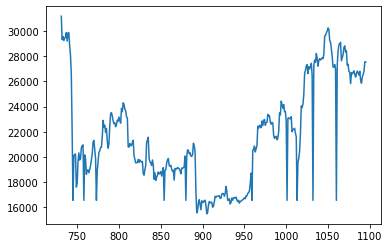

In [37]:
plt.plot(df['value'])

In [82]:
df.isnull().sum()

date     0
value    0
dtype: int64

# Проверка на стационарность

In [42]:
adfuller(df['value']) 

(-2.350782389104545,
 0.15611203096604576,
 3,
 361,
 {'1%': -3.4485948978753314,
  '5%': -2.86957971128312,
  '10%': -2.571053050314224},
 5998.233080206636)

p-значение больше 0,05

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


# Работа с моделями

In [39]:
train_df = df[df.date < pd.to_datetime('2023-05-01')]
test_df = df[df.date >= pd.to_datetime('2023-05-01')]

In [40]:
train_df.shape

(335, 2)

In [41]:
test_df.shape

(30, 2)

In [113]:
# Moving Avarage
AR = AutoReg(train_df.value.values, lags=18)
AR_model = AR.fit()

In [114]:
AR_model.predict(start=len(train_df),
                 end=len(train_df) + len(test_df)-1)

array([28122.41069796, 29200.85906122, 28350.36074853, 28726.9020284 ,
       28812.89994915, 28277.44474393, 26213.2413333 , 26457.02267215,
       27904.31438613, 26881.65690213, 27233.57822575, 27777.22176266,
       27516.9563602 , 27527.57905915, 27581.60820485, 27370.50892407,
       27695.93525233, 27567.01403175, 27083.49011348, 26899.13011187,
       27097.46058817, 26826.83144234, 26627.71150209, 26855.85469783,
       26794.23566967, 26672.09837597, 26710.61844404, 26641.36788715,
       26647.87500659, 26682.13647419])

In [115]:
test_df['AR_model_prediction'] = AR_model.predict(start =len(train_df),
                                                  end= len(train_df) + len(test_df)-1)

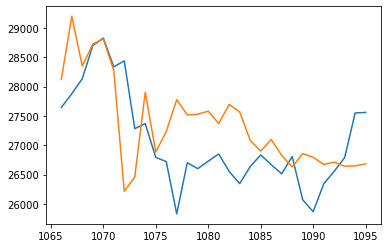

In [116]:
plt.plot(test_df[['value', 'AR_model_prediction']])

In [117]:
from sklearn.metrics import mean_absolute_error

print('MAE MA_model: ', mean_absolute_error(test_df['value'],
                                            test_df['AR_model_prediction']))


MAE MA_model:  643.9175173313918


In [118]:
from sklearn.metrics import mean_squared_error
print('RMSE MA_model: ', mean_squared_error(test_df['value'],
                                            test_df['AR_model_prediction'])**0.5)

RMSE MA_model:  838.7056085457026


# ARMA

In [163]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

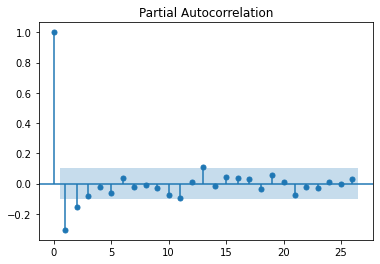

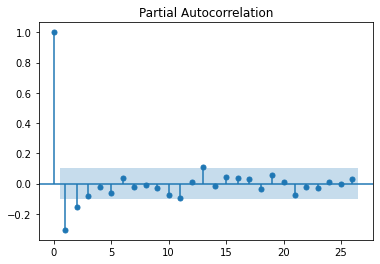

In [175]:
plot_pacf(df.value.diff().dropna()) #подбираем значение p

1 значительный выброс, поэтому p=1

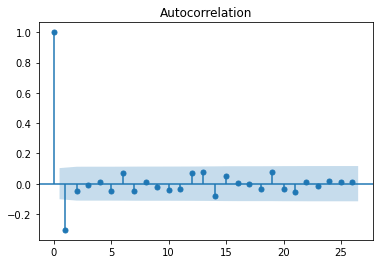

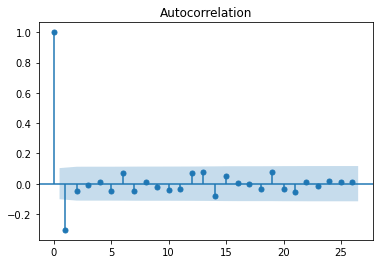

In [174]:
plot_acf(df.value.diff().dropna()) #подбираем q

q=2, потому что есть два выброса

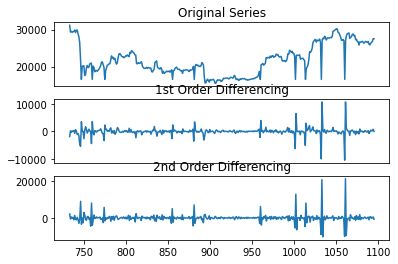

In [172]:
#подбираем d
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df.value); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df.value.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df.value.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

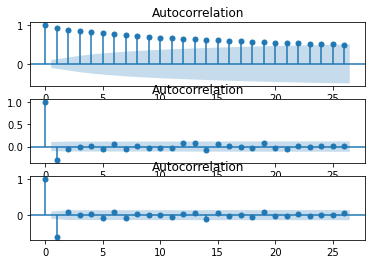

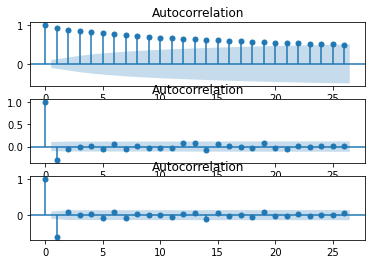

In [182]:
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df.value, ax=ax1)
plot_acf(df.value.diff().dropna(), ax=ax2)
plot_acf(df.value.diff().diff().dropna(), ax=ax3)

как будто d=1, но с таким значением метрики получаются хуже, поэтому я решила оставить ноль

In [192]:
ARMA = ARIMA(train_df.value.values, order=(1,0,2))
ARMA_model = ARMA.fit()

In [193]:
test_df['ARMA_model_prediction'] = ARMA_model.predict(
    start=len(train_df), end=len(train_df) + len(test_df)-1)

In [194]:
print('MAE MA_model: ', mean_absolute_error(test_df['value'],
                                            test_df['ARMA_model_prediction']),
     'RMSE MA_model: ', mean_squared_error(test_df['value'],
                                            test_df['ARMA_model_prediction'])**0.5)

MAE MA_model:  562.90495992999 RMSE MA_model:  728.089327770143


# ARIMA

In [208]:
ARIMA_ = ARIMA(train_df.value.values, order=(2,0,5))
ARIMA_model = ARIMA_.fit()

In [209]:
ARIMA_model.predict(start=len(train_df),
                    end=len(train_df) + len(test_df)-1)

array([28214.20879624, 28525.631493  , 28030.96151886, 28167.17506842,
       27852.40253626, 27895.06017617, 27665.02508811, 27648.84889647,
       27470.74193722, 27420.85102378, 27275.06019471, 27206.38932589,
       27081.17444987, 27002.58637993, 26890.90315699, 26807.64099496,
       26705.24695849, 26620.39660619, 26524.72155064, 26440.08379137,
       26349.55609923, 26266.16662931, 26179.81147809, 26098.25098824,
       26015.45069629, 25936.02974925, 25856.38081565, 25779.25005904,
       25702.47786891, 25627.69372259])

In [210]:
test_df['ARIMA_model_prediction'] = ARIMA_model.predict(
    start=len(train_df), end=len(train_df) + len(test_df)-1)

In [211]:
print('MAE MA_model: ', mean_absolute_error(test_df['value'],
                                            test_df['ARIMA_model_prediction']),
     'RMSE MA_model: ', mean_squared_error(test_df['value'],
                                            test_df['ARIMA_model_prediction'])**0.5)

MAE MA_model:  542.1767918813101 RMSE MA_model:  719.6081694177843


нужно добиться результата чтобы RMSE<=1500

все по этапам
- посмотреть на пропуски и заполнить их разными способами (на графике можно визуально проверить какой вариант будет лучше, тк не все методы тут хорошо подойдут, плюс по метрикам будет тоже видно)
- проверка временного ряда на стационарность
- выбор модели, тюнинг (различные параметры p,d,q, также можно попробовать модель с сезонностью)

помимо моделей из лекции можно использовать lstm, prophet, бустинги (если будет желание)

у меня получилось RMSE в одной из модели ±1000

если RMSE<=1500  это 100 баллов
за каждые 10% от 1500 будут хуже баллы

rmse 1750 - баллов будет 90
rmse 1900 - баллов будет 80
и тд

надеюсь понятно объяснил)

решения можете присылать отчетом со ссылкой на гит с кодом